In [2]:
import os
from os import listdir
import numpy as np
import nibabel as nib #for reading .nii.gz format MRI files
import matplotlib.pyplot as plt
import pandas as pd
#import cv2 #opencv

In [ ]:
import timm
import torch

In [6]:
# default model with classifier
m0 = timm.create_model("mobilevit_xxs.cvnets_in1k", pretrained=True)
print(m0)

ByobNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (shortcut): Identity()
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
          

In [12]:
# We want Penultimate Layer Features (Pre-Classifier Features), not classification
# this one ends with:
#   (fc): Identity()
#   (flatten): Identity()
m1 = timm.create_model("mobilevit_xxs.cvnets_in1k", pretrained=True, num_classes=0, global_pool='')

# pretrained weights need <batch B, 3 channels, H, W>:
# ex. (1, 3, 224, 224) -> torch.Size([1,1000]) if classifier
# ex.                  -> torch.Size([1, 320, 7, 7]) if preclassifier (no classifier head & pooling)
# ex. (1, 3, 96, 96)   -> torch.Size([1, 320, 3, 3]) if classifier
x = torch.randn(1, 3, 96, 96) 
o = m1(x)  
#print(m1)

In [17]:
# MobileViTv2
# This one with LinearTransformerBlock(...), LinearSelfAttention(...) classes 
#   crop_pct=0.888?
m2 = timm.create_model("mobilevitv2_050.cvnets_in1k", pretrained=True, num_classes=0, global_pool='')

# pretrained weights need <batch B, 3 channels, H, W>:
# ex. (1, 3, 224, 224) -> torch.Size([1,1000]) if classifier
# ex.                  -> torch.Size([1, 256, 8, 8]) if preclassifier (no classifier head & pooling)
# ex. (1, 3, 96, 96)   -> torch.Size([1, 256, 4, 4]) if classifier
x = torch.randn(1, 3, 224, 224) 
o = m2(x)
print(o.shape)  
#print(m2)

torch.Size([1, 256, 8, 8])


### Load Images

In [ ]:
#os.chdir("/Users/rita/Desktop")
#cwd = os.getcwd() #/Users/rita/Desktop/
#print(cwd)

file_dir = 'harini_lab/PROSTATEx/Files/lesions/'
csvFile_image = pd.read_csv(os.path.join(file_dir,'image_list.csv'))
csvFile_score = pd.read_csv(os.path.join(file_dir,'prostatex_classes.csv'))

img_dir_ADC = os.path.join(file_dir, 'Images/ADC') #lesions/Images/ADC/X.nii.gz
img_dir_T2 = os.path.join(file_dir, 'Images/T2') #lesions/Images/T2/X.nii.gz


In [ ]:
# example images
img_filename_ADC, img_filename_T2 = csvFile_image.iloc[10] #change for different imgs

img_complete_path_ADC = os.path.join(img_dir_ADC, img_filename_ADC) + '.nii.gz'
img_ADC = nib.load(img_complete_path_ADC)
imgdata_ADC = img_ADC.get_fdata() #(84, 128, 19)

slice_ADC = imgdata_ADC[:,:,14] #(mask at 13~17) #(84,128)
#plt.imshow(slice_ADC.T, cmap='Greys_r'); plt.title("Example ADC Image")

img_complete_path_T2 = os.path.join(img_dir_T2, img_filename_T2) + '.nii.gz'
img_T2 = nib.load(img_complete_path_T2)
imgdata_T2 = img_T2.get_fdata() #(384, 384, 19)

slice_T2 = imgdata_T2[:,:,14]
plt.imshow(slice_T2.T, cmap='Greys_r'); plt.title("Example T2 Image")
print(slice_T2.shape) 

### Playground

(384, 384)


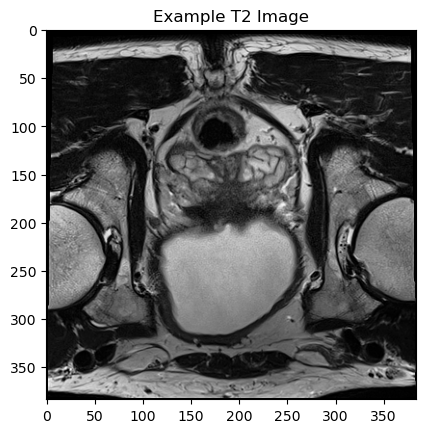

In [10]:
#np.save('ex_ADC', slice_ADC)

#load example image
x = np.load('ex_T2.npy') 
plt.imshow(x.T, cmap='Greys_r'); plt.title("Example T2 Image")
print(x.shape) 

In [18]:
# Example code from HF (Image Classification)
#   https://huggingface.co/timm/mobilevitv2_050.cvnets_in1k 
from urllib.request import urlopen
from PIL import Image
#import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

#model = timm.create_model('mobilevitv2_050.cvnets_in1k', pretrained=True)
m1 = m1.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(m1)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = m1(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


torch.Size([1, 320, 8, 8])


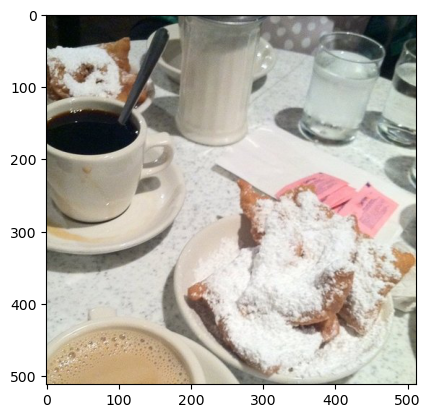

In [26]:
plt.imshow(img)
#print(output.shape)             #[1, 320, 8, 8]
#print(top5_class_indices.shape) #[1, 320, 8, 5]
#print(top5_probabilities.shape) #[1, 320, 8, 5]

In [ ]:
# Feature map
m = timm.create_model('mobilevit_xxs.cvnets_in1k', features_only=True, pretrained=True)

x = slice_T2
o = m(x) #list with len=5 tensors

print(len(o))